# Lecture 6b: Neural Network Learning Part 4

3/23/2023

## Using Keras Library:
 
 - Multi Class Classification

#### Import Libraries:

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from random import randint
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical # Convert Class Vectors to Binary Class Matrices
from sklearn.metrics import accuracy_score, confusion_matrix

#### Define Functions For Plotting:

In [2]:
# plot data points
def plot_fun(features, labels, classes, plotRange):
    plt.plot(features[labels[:] == classes[0], 0], features[labels[:] == classes[0], 1], 'rs',
             features[labels[:] == classes[1], 0], features[labels[:] == classes[1], 1], 'g^')
    plt.axis(plotRange)
    plt.title('Raw Data Plot For Both Classes')
    plt.xlabel('X_1: Feature 1')
    plt.ylabel('X_2: Feature 2')
    plt.legend(['Class ' + str(classes[0]), 'Class ' + str(classes[1])])
    plt.show()

# plot separating line: w1x1 + w2x2 + w0 = 0
def plot_fun_thr(features, labels, thresholdParams, learnRate, batchSize, classes):
    # plot data points
    plt.plot(features[labels[:] == classes[0], 0], features[labels[:] == classes[0], 1], 'rs',
             features[labels[:] == classes[1], 0], features[labels[:] == classes[1], 1], 'g^')
    plt.axis([-3, 3, -2, 4])
    # plot separating line
    x1 = np.linspace(-3, 3, 50)
    # w1x1 + w2x2 + w0 = 0 => x2 = -(w1x1 + w0) / w2
    x2 = -(thresholdParams[0] * x1 + thresholdParams[2]) / thresholdParams[1]
    plt.plot(x1, x2, '-b')
    plt.title(f'Data Classification:\nLearn Rate = {learnRate}, Batch Size = {batchSize}')
    plt.xlabel('X_1: Feature 1')
    plt.ylabel('X_2: Feature 2')
    plt.legend(['Class ' + str(classes[0]), 'Class ' + str(classes[1])])
    #plt.pause(0.5)
    #plt.show()

# plot training accuracy and loss
def plotCurve(trainingAccuracy, trainingLoss):
    epochs = np.arange(trainingLoss.shape[0])
    #print(epochs)
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainingAccuracy)
    #plt.axis([-1, 2, -1, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainingLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy Loss')
    plt.title('Training Loss')
    plt.show()

# Plot MNIST Images in subplots
def img_plt(img, label):
    plt.figure(figsize=(12, 5.5))
    for i in range (1, 11):
        plt.subplot(2, 5, i)
        plt.imshow(img[i - 1, :, :], cmap = 'gray')
        plt.title('Label: ' + str(label[i - 1]))
    plt.show()

# Plot Features of MNIST data
def feat_plot(features, labels, classes, title):
    for class_i in classes:
        plt.plot(features[labels[:] == classes[class_i], 0],
                 features[labels[:] == classes[class_i], 1], 'o', markersize = 5)
        # plt.axis([-2, 2, -2, 2])
        plt.xlabel('X: Feature 1')
        plt.ylabel('Y: Feature 2')
        plt.title(title)
        plt.legend(['Class ' + str(classes[class_i]) for class_i in classes])
    plt.show()

#### Define Function For Feature Extraction From MNIST Images:

In [3]:
def feat_extract_mult(images):
    width = images.shape[1]
    height = images.shape[2]
    features = np.zeros((images.shape[0], 4))

    features_temp = np.sum(images[:, 0:int(width / 2), 0:int(height / 2)], axis = 2) # Quadrant 0
    features[:,0] = np.sum(features_temp, axis = 1) / (width * height / 4) # Average Pixel Values
    
    features_temp = np.sum(images[:, 0:int(width / 2), int(height / 2):], axis = 2) # Quadrant 1
    features[:,1] = np.sum(features_temp, axis = 1) / (width * height / 4) # Average Pixel Values
    
    features_temp = np.sum(images[:, int(width / 2):, 0:int(height / 2)], axis = 2) # Quadrant 2
    features[:,2] = np.sum(features_temp, axis = 1) / (width * height / 4) # Average Pixel Values
    
    features_temp = np.sum(images[:, int(images.shape[1] / 2):, int(images.shape[2] / 2):], axis = 2) # Quadrant 3
    features[:,3] = np.sum(features_temp, axis = 1) / (width * height / 4) # Average Pixel Values
    return features

## Keras For Multiclass Classification:

#### Load MNIST Dataset & Split Into Training & Testing Sets:

In [4]:
# Load Data and Split to Training and Testing Sets:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#print(x_train.shape) # (60000, 28, 28)
#print(y_train.shape) # (60000,)
#print(x_test.shape) # (10000, 28, 28)
#print(y_test.shape) # (10000,)

print('The number of Training Images =', x_train.shape[0])
print('The number of Training Labels =', y_train.shape[0])
print('The size of each Training Image is:', x_train.shape[1], 'by', x_train.shape[2], 'pixels \n')
print('The number of Testing Images =', x_test.shape[0])
print('The number of Testing Labels =', y_test.shape[0])
print('The size of each Testing Image is:', x_test.shape[1], 'by', x_test.shape[2], 'pixels')

The number of Training Images = 60000
The number of Training Labels = 60000
The size of each Training Image is: 28 by 28 pixels 

The number of Testing Images = 10000
The number of Testing Labels = 10000
The size of each Testing Image is: 28 by 28 pixels


#### Plot Digits 0 - 9 From The Training Set:

 - For Each Digit, Select A Random Sample.

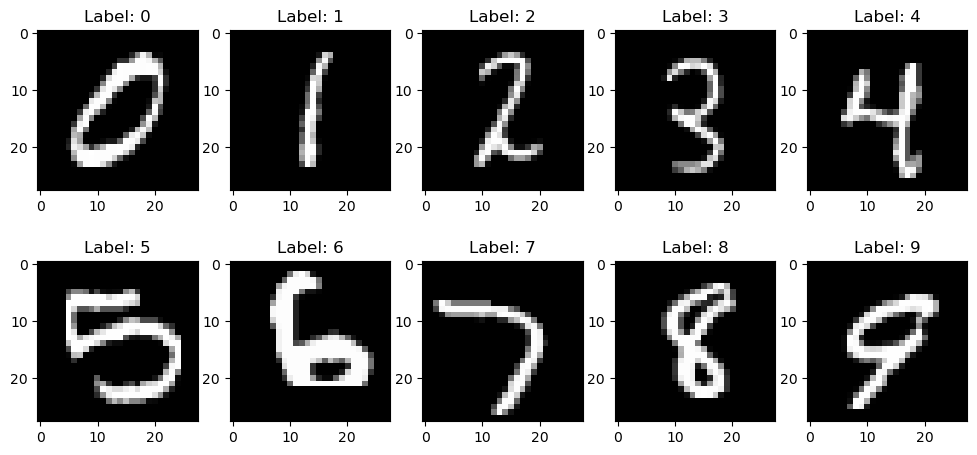

In [5]:
# Select 10 images from the training set
x_train_rnd = np.zeros((10, 28, 28))
y_train_rnd = np.arange(10)

for digit in range(10): # finds 10 images from the set
    x_train_d = x_train[y_train == digit,:,:]
    #x_train_rnd[digit,:,:] = x_train_d[0,:,:] # Select FIRST Digits From Set
    x_train_rnd[digit,:,:] = x_train_d[randint(0, x_train_d.shape[0]),:,:] # Select RANDOM Digits From Set

img_plt(x_train_rnd, y_train_rnd) # plot the images

#### Check Training and Test Sets For Proper Size:

In [6]:
# Check Training Data Set for correct amount of images:
x_train_TEST0 = x_train[y_train == 0] # Select all Zeros in Training Set
x_train_TEST1 = x_train[y_train == 1] # Select all Ones in Training Set
x_train_TEST2 = x_train[y_train == 2] # Select all Twos in Training Set
#print(x_train_TEST0.shape)
#print(x_train_TEST1.shape)
#print(x_train_TEST2.shape)

total1 = x_train_TEST0.shape[0] + x_train_TEST1.shape[0] + x_train_TEST2.shape[0] 
print(f'Total # of 0\'s, 1\'s & 2\'s in Training Set should be: {x_train_TEST0.shape[0]} + {x_train_TEST1.shape[0]} + {x_train_TEST2.shape[0]} = {total1}\n')

# Check Test Data Set for correct amount of images:
x_test_TEST0 = x_test[y_test == 0] # Select all Zeros in Testing Set
x_test_TEST1 = x_test[y_test == 1] # Select all Ones in Testing Set
x_test_TEST2 = x_test[y_test == 2] # Select all Ones in Testing Set
#print(x_test_TEST0.shape)
#print(x_test_TEST1.shape)
#print(x_test_TEST2.shape)

total2 = x_test_TEST0.shape[0] + x_test_TEST1.shape[0] + x_test_TEST2.shape[0]
print(f'Total # of 0\'s, 1\'s & 2\'s in Test Set should be: {x_test_TEST0.shape[0]} + {x_test_TEST1.shape[0]} + {x_test_TEST2.shape[0]} = {total2}\n')

Total # of 0's, 1's & 2's in Training Set should be: 5923 + 6742 + 5958 = 18623

Total # of 0's, 1's & 2's in Test Set should be: 980 + 1135 + 1032 = 3147



### Select MNIST Digits 0, 1 and 2:
 
 - Select All 0's, 1's & 2's From Training & Testing Sets.
 - Create an array of the images.
 - Create a 2nd array of labels for the images.

In [7]:
# Create a boolean mask to select images of digits 0, 1, and 2
train_mask_012 = np.isin(y_train, [0, 1, 2])

# Use boolean indexing to select the corresponding images and labels
x_train_012 = x_train[train_mask_012]
y_train_012 = y_train[train_mask_012]

#print(x_train_012.shape) # debug
#print(y_train_012.shape) # debug
print(f'Total Number of 0\'s, 1\'s & 2\'s in \'x_train_012\' is: {x_train_012.shape[0]}\n')

test_mask_012 = np.isin(y_test, [0, 1, 2])

# Use boolean indexing to select the corresponding images and labels
x_test_012 = x_test[test_mask_012]
y_test_012 = y_test[test_mask_012]

#print(x_test_012.shape) # debug
#print(y_test_012.shape) # debug
print(f'Total Number of 0\'s, 1\'s & 2\'s in \'x_test_012\' is: {x_test_012.shape[0]}\n')

Total Number of 0's, 1's & 2's in 'x_train_012' is: 18623

Total Number of 0's, 1's & 2's in 'x_test_012' is: 3147



#### Plot Random Images From New Testing and Training Sets:

Random Images From Training Set: 



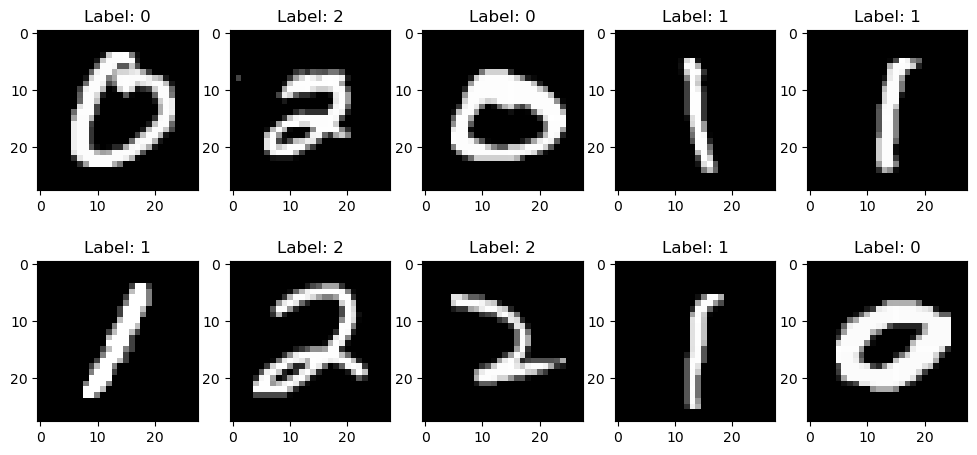

Random Images From Testing Set: 



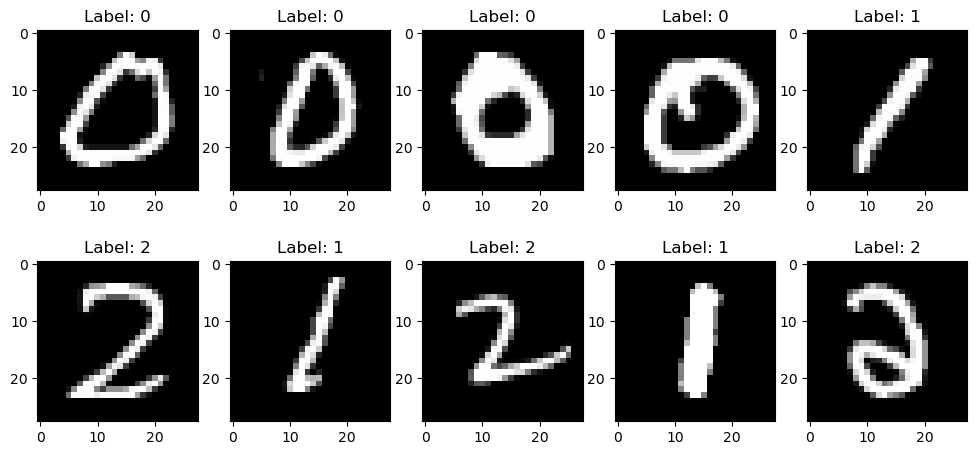

In [8]:
# Select 10 random images and their labels from x_train_012 and y_train_012
rnd_indices = np.random.choice(x_train_012.shape[0], size=10, replace=False)
rnd_images = x_train_012[rnd_indices]
rnd_labels = y_train_012[rnd_indices]

print('Random Images From Training Set: \n')
img_plt(rnd_images, rnd_labels)

rnd_indices2 = np.random.choice(x_test_012.shape[0], size=10, replace=False)
rnd_images2 = x_test_012[rnd_indices2]
rnd_labels2 = y_test_012[rnd_indices2]

print('Random Images From Testing Set: \n')
img_plt(rnd_images2, rnd_labels2)

#### Divide Training Set Into Training and Validation Sets

 - Create Shuffled Array Indices.
 - Shuffle Training and Testing Data.
 - Pull 1st 500 Images from Training Set and Designate as Validation Set.
    - The Remainder Of The Training Set is the New Training Set.

In [9]:
# create array with 11774 indices for TRAINING:
train_indices = np.arange(0, x_train_012.shape[0])
#print(train_indices)

# create array with 1954 indices for TESTING:
test_indices = np.arange(0, x_test_012.shape[0])
#print(test_indices, '\n')

# shuffle the indices of the training array
shuffled_indices_train = np.random.permutation(train_indices)
#print(shuffled_indices_train)

# shuffle the indices of the testing array
shuffled_indices_test = np.random.permutation(test_indices)
#print(shuffled_indices_test, '\n')

# create arrays of SHUFFLED TRAINING data
x_shuffled_all_train = x_train_012[shuffled_indices_train,:,:]
y_shuffled_all_train = y_train_012[shuffled_indices_train]
#print(x_shuffled_all_train.shape)
#print(y_shuffled_all_train.shape, '\n')

# create arrays of SHUFFLED TESTING data
x_shuffled_all_test = x_test_012[shuffled_indices_test,:,:]
y_shuffled_all_test = y_test_012[shuffled_indices_test]
#print(x_shuffled_all_test.shape)
#print(y_shuffled_all_test.shape, '\n')

# create validation set of 500 random images FROM SHUFFLED training set
x_valid_012 = x_shuffled_all_train[0:500,:,:]
y_valid_012 = y_shuffled_all_train[0:500]
print(x_valid_012.shape)
print(y_valid_012.shape, '\n')

# pull the rest of the images (11774 - 500 = 11274) FROM SHUFFLED training set
x_train_012 = x_shuffled_all_train[500:,:,:]
y_train_012 = y_shuffled_all_train[500:]
print(x_train_012.shape)
print(y_train_012.shape, '\n')

# SHUFFLE the TESTING Set
x_test_012 = x_shuffled_all_test[:]
y_test_012 = y_shuffled_all_test[:]
print(x_test_012.shape)
print(y_test_012.shape)

(500, 28, 28)
(500,) 

(18123, 28, 28)
(18123,) 

(3147, 28, 28)
(3147,)


#### Check Number Of Images In Training, Testing and Validation Sets:

In [10]:
print(f'The number of images in \'x_train_012\' Training Set = {x_train_012.shape[0]}')
print(f'The number of labels in \'y_train_012\' Training Set = {y_train_012.shape[0]}\n')

print(f'The number of images in \'x_valid_012\' Validation Set = {x_valid_012.shape[0]}')
print(f'The number of labels in \'y_valid_012\' Validation Set = {y_valid_012.shape[0]}\n')

print(f'The number of images in \'x_test_012\' Testing Set = {x_test_012.shape[0]}')
print(f'The number of labels in \'y_test_012\' Testing Set = {y_test_012.shape[0]}')

The number of images in 'x_train_012' Training Set = 18123
The number of labels in 'y_train_012' Training Set = 18123

The number of images in 'x_valid_012' Validation Set = 500
The number of labels in 'y_valid_012' Validation Set = 500

The number of images in 'x_test_012' Testing Set = 3147
The number of labels in 'y_test_012' Testing Set = 3147


#### Plot 10 Images From The Validation Set:
 - These indices are now randomized

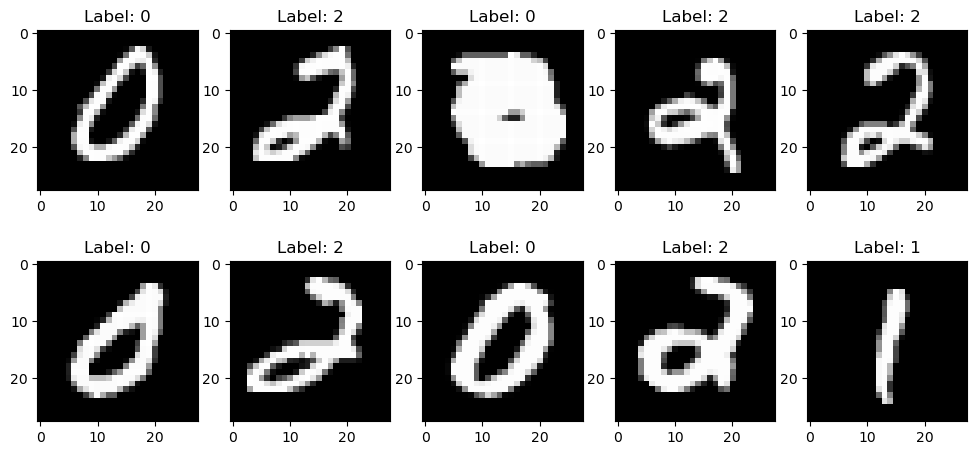

In [11]:
img_plt(x_valid_012[0:10,:,:], y_valid_012[0:10]) # Select First 10 images from the set

#### Extract And Plot Features of 500 Training Images:

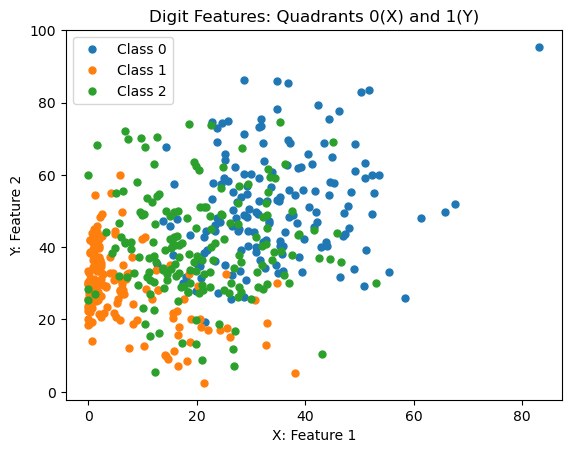

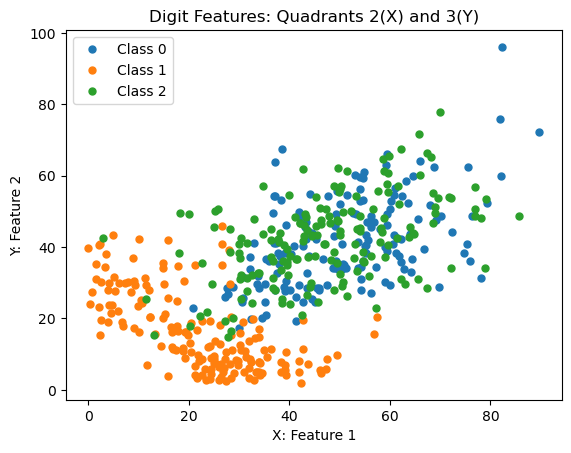

In [12]:
classes2 = [0, 1, 2]
feature_train2 = feat_extract_mult(x_train_012)
feature_valid2 = feat_extract_mult(x_valid_012)
feature_test2 = feat_extract_mult(x_test_012)

feat_plot(feature_train2[0:500, 0:2], y_train_012[0:500], classes2, 'Digit Features: Quadrants 0(X) and 1(Y)')
feat_plot(feature_train2[0:500, 2:4], y_train_012[0:500], classes2, 'Digit Features: Quadrants 2(X) and 3(Y)')

#### Define Model For Multiclass Classification:
 
 - Hidden Layer 1: 4 features (1 per image quadrant).
 - Hidden Layer 2: 16 neurons.
 - Output Layer: 3 neurons (1 per class).
     - Softmax is used for multiclass classification.
     - Output of Softmax is a vector of probabilities according to class identification: 
$$
  P(x_n) = 
  \begin{bmatrix}
    P(x_0)\\
    P(x_1)\\
    P(x_2)
  \end{bmatrix}
$$

In [17]:
model2 = Sequential()
model2.add(Dense(input_dim = 4, units = 256, activation = 'tanh')) # Hidden Layer 1 (also try 'relu' activation)
model2.add(Dense(units = 16, activation = 'tanh')) # Hidden Layer 2 (also try 'relu' activation)
model2.add(Dense(units = len(classes2), activation = 'softmax')) # Output Layer
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               1280      
                                                                 
 dense_4 (Dense)             (None, 16)                4112      
                                                                 
 dense_5 (Dense)             (None, 3)                 51        
                                                                 
Total params: 5,443
Trainable params: 5,443
Non-trainable params: 0
_________________________________________________________________


#### Compile & Fit The Model:

In [14]:
y_train_012_c = to_categorical(y_train_012, len(classes2))
y_valid_012_c = to_categorical(y_valid_012, len(classes2))
y_test_012_c = to_categorical(y_test_012, len(classes2))

opt2 = tf.keras.optimizers.SGD(learning_rate = 0.0001) # Stochastic Gradient Descent
model2.compile(loss='categorical_crossentropy', optimizer=opt2, metrics=['accuracy'])

history2 = model2.fit(feature_train2, y_train_012_c, batch_size=16, epochs=50, verbose=1)

Epoch 1/50
1133/1133 [==============================] - 1s 985us/step - loss: 0.8261 - accuracy: 0.6923
Epoch 2/50
1133/1133 [==============================] - 1s 896us/step - loss: 0.5586 - accuracy: 0.8712
Epoch 3/50
1133/1133 [==============================] - 1s 877us/step - loss: 0.4786 - accuracy: 0.8829
Epoch 4/50
1133/1133 [==============================] - 1s 1ms/step - loss: 0.4391 - accuracy: 0.8863
Epoch 5/50
1133/1133 [==============================] - 1s 954us/step - loss: 0.4126 - accuracy: 0.8874
Epoch 6/50
1133/1133 [==============================] - 1s 904us/step - loss: 0.3930 - accuracy: 0.8897
Epoch 7/50
1133/1133 [==============================] - 1s 997us/step - loss: 0.3779 - accuracy: 0.8910
Epoch 8/50
1133/1133 [==============================] - 1s 926us/step - loss: 0.3661 - accuracy: 0.8904
Epoch 9/50
1133/1133 [==============================] - 1s 931us/step - loss: 0.3566 - accuracy: 0.8910
Epoch 10/50
1133/1133 [==============================] - 1s 928us/

#### Evaluate Model & Plot Training Accuracy and Loss:

99/99 [==============================] - 0s 778us/step - loss: 0.2951 - accuracy: 0.8910

Total Loss From Test Set:  0.2950511872768402
Accuracy of Test Set:  0.8910073041915894 

16/16 [==============================] - 0s 778us/step - loss: 0.2530 - accuracy: 0.9140

Total Loss From Validation Set:  0.2529541552066803
Accuracy of Validation Set:  0.9139999747276306 



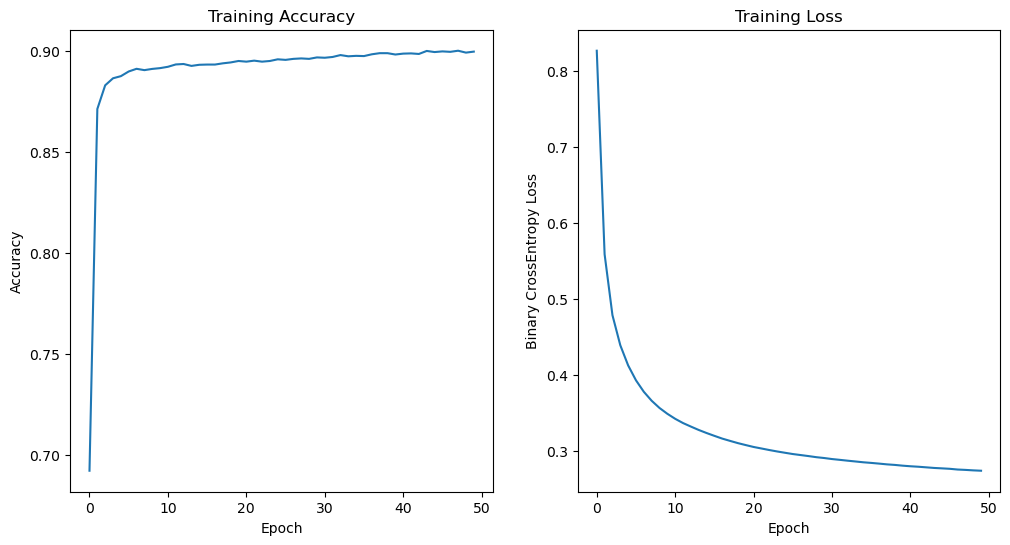

In [15]:
scoreTest2 = model2.evaluate(feature_test2, y_test_012_c)
print('\nTotal Loss From Test Set: ', scoreTest2[0])
print('Accuracy of Test Set: ', scoreTest2[1], '\n')

scoreValid2 = model2.evaluate(feature_valid2, y_valid_012_c)
print('\nTotal Loss From Validation Set: ', scoreValid2[0])
print('Accuracy of Validation Set: ', scoreValid2[1], '\n')

accuracyCurve2 = np.array(history2.history['accuracy'])
lossCurve2 = np.array(history2.history['loss'])
plotCurve(accuracyCurve2, lossCurve2)

#### Predict Class Of Held Out Samples & Calculate Evaluation Metrics:

 - np.argmax: determine highest value of each row (image) per column (class)
     - This will predict which class each image belongs to.

In [16]:
testClass2Prob = model2.predict(feature_test2)
testLabels2 = np.argmax(testClass2Prob, axis = 1)

testAccuracy2 = accuracy_score(testLabels2, y_test_012)
print('\nThe Accuracy Using The Test Set = ', testAccuracy2)

confusionMatrix2 = confusion_matrix(testLabels2, y_test_012)
print('\nThe Confusion Matrix Using Testing Set Is: \n', confusionMatrix2)

99/99 [==============================] - 0s 661us/step

The Accuracy Using The Test Set =  0.8910073085478233

The Confusion Matrix Using Testing Set Is: 
 [[ 896   23  167]
 [   9 1081   38]
 [  75   31  827]]
